# **DATOS CIENTÍFICOS**

**ITBA - Maestría en Ciencia de Datos - 2023**

**Trabajo Práctico - Alen Jiménez**

El objetivo de esta notebook es analizar datos provenientes de sensores de ondas cerebrales, que se estructuran en series de tiempo.

# Tabla de Contenidos
* [Set Up](#setup)
* [Análisis Estadístico y Gráfico](#analisis_estadistico_grafico)
* [Filtros](#filtros)
    * [Espacial](#espacial)
    * [Temporal](#temporal)
    * [Espectral](#expectral)

# Set Up <a class = 'anchor' id = 'setup'></a>

In [60]:
# Importamos bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
import os
import sys, select
import time
import datetime
import math
from scipy import stats
from scipy.fftpack import fft
from scipy.signal import firwin, remez, kaiser_atten, kaiser_beta
from scipy.signal import butter, filtfilt, buttord
from scipy.signal import butter, lfilter


In [3]:
# Directorio de trabajo

directorio_de_trabajo = 'C:/itba_datos_geograficos/ramele/tp'
os.chdir(directorio_de_trabajo)
print(f'Directorio actual de trabajo: {os.getcwd()}')

Directorio actual de trabajo: C:\itba_datos_geograficos\ramele\tp


In [4]:
# Importamos las series de tiempo de las ondas cerebrales para cada comportamiento medido

# creamos lista con los nombres de los archivos
nombres_archivos = ['ojosabiertos','ojoscerrados','pestaneos','si','no','verdad','mentira', 'meditacion']

# creamos diccionario conteniendo los df's
dataframes_dict = {}

for nombre_archivo in nombres_archivos:

    # importamos el archivo
    df = pd.read_csv('datos/%s.dat' % nombre_archivo
                    , delimiter = ' '
                    , names = ['timestamp','counter','eeg','attention','meditation','blinking'])
    
    # creamos nombre especifico de df
    df_name = f'{nombre_archivo}'
    
    # asignamos el df al diccionario
    dataframes_dict[df_name] = df


# Análisis Estadístico y Gráfico <a class = 'anchor' id = 'analisis_estadistico_grafico'></a>

In [84]:
# Shape de dfs

print('Filas y columnas por cada dataframe:\n')
for df in nombres_archivos:
    print(f'%s:{dataframes_dict[df].shape}' % df)

Filas y columnas por cada dataframe:

ojosabiertos:(30850, 6)
ojoscerrados:(30887, 6)
pestaneos:(30840, 6)
si:(30856, 6)
no:(30840, 6)
verdad:(30847, 6)
mentira:(30850, 6)
meditacion:(92540, 6)


In [85]:
# Vemos información general del dataset

for df in nombres_archivos:
    print('\nInformación general de las columnas de %s:\n' % df)
    dataframes_dict[df].info()


Información general de las columnas de ojosabiertos:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30850 entries, 0 to 30849
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   30850 non-null  float64
 1   counter     30850 non-null  int64  
 2   eeg         30850 non-null  int64  
 3   attention   30850 non-null  int64  
 4   meditation  30850 non-null  int64  
 5   blinking    30850 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 1.4 MB

Información general de las columnas de ojoscerrados:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30887 entries, 0 to 30886
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   30887 non-null  float64
 1   counter     30887 non-null  int64  
 2   eeg         30887 non-null  int64  
 3   attention   30887 non-null  int64  
 4   meditation  30887 non-null  int64  
 5   blin

In [95]:
# Descripción estadística general de los datos de las columnas

for df in nombres_archivos:
    print('\nDescripción estadísticas de la columna eeg de %s:\n' % df)
    print(dataframes_dict[df]['eeg'].describe())


Descripción estadísticas de la columna eeg de ojosabiertos:

count    30850.000000
mean        30.734263
std        201.230052
min       -636.000000
25%          1.000000
50%         42.000000
75%         88.000000
max        938.000000
Name: eeg, dtype: float64

Descripción estadísticas de la columna eeg de ojoscerrados:

count    30887.000000
mean        29.940363
std         37.405551
min       -154.000000
25%          5.000000
50%         29.000000
75%         55.000000
max        189.000000
Name: eeg, dtype: float64

Descripción estadísticas de la columna eeg de pestaneos:

count    30840.000000
mean        30.172990
std        216.335592
min       -929.000000
25%        -69.000000
50%         28.000000
75%        122.000000
max       1025.000000
Name: eeg, dtype: float64

Descripción estadísticas de la columna eeg de si:

count    30856.000000
mean        30.444873
std        167.998560
min       -747.000000
25%        -42.000000
50%         32.000000
75%        105.000000
max  

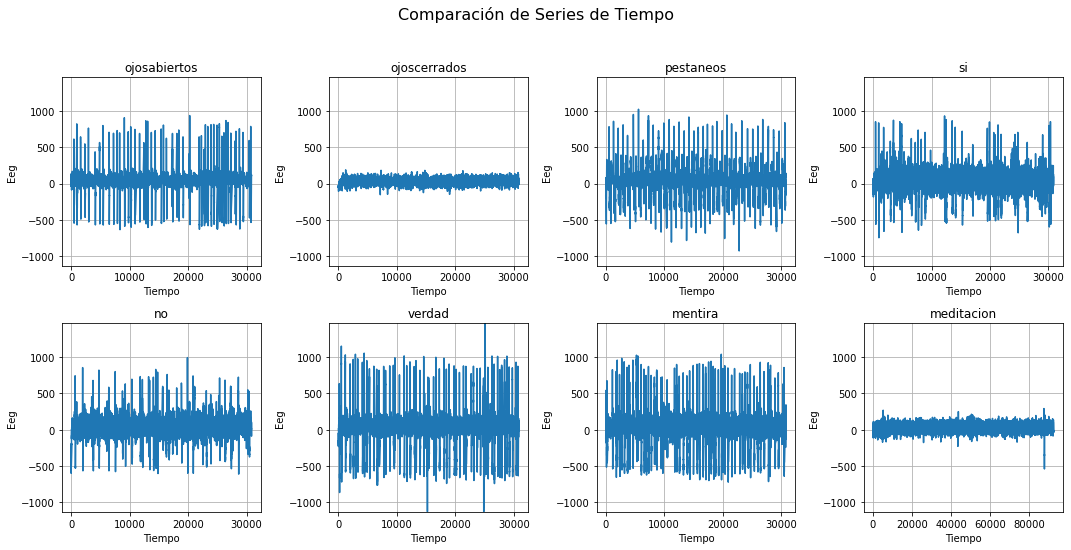

In [149]:
# Numero de filas y de columnas para los subplots

num_rows = 2
num_cols = 4

# Grafico

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
fig.suptitle("Comparación de Series de Tiempo", fontsize=16)

y_axis_min = min(dataframes_dict[df]["eeg"].min() for df in nombres_archivos)
y_axis_max = max(dataframes_dict[df]["eeg"].max() for df in nombres_archivos)

for i, df in enumerate(nombres_archivos):
    
    row_index = i // num_cols
    col_index = i % num_cols

    x = range(len(dataframes_dict[df]["eeg"]))
    
    axes[row_index, col_index].plot(x, dataframes_dict[df]["eeg"])
    axes[row_index, col_index].grid()
    axes[row_index, col_index].set_title(df)
    axes[row_index, col_index].set_xlabel("Tiempo")
    axes[row_index, col_index].set_ylabel("Eeg")
    axes[row_index, col_index].set_ylim(y_axis_min, y_axis_max)

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# Filtros <a class = 'anchor' id = 'filtros'></a>

## Temporal <a class = 'anchor' id = 'temporal'></a>

In [33]:
# La operación de convolución permite implementar el suavizado del Moving Average
windowlength = 512

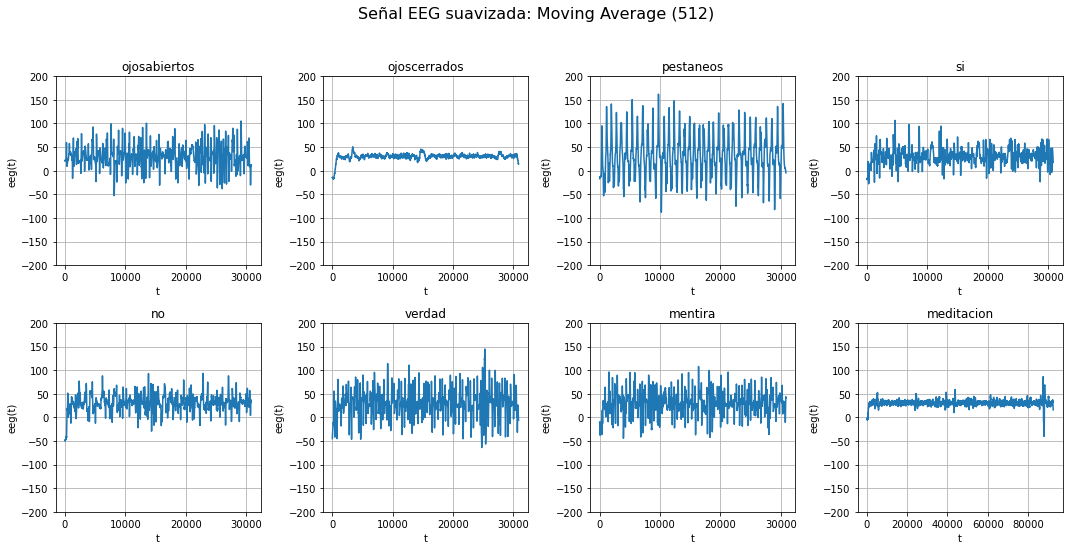

In [148]:
# Numero de filas y de columnas para los subplots

num_rows = 2
num_cols = 4

# Grafico

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
fig.suptitle("Señal EEG suavizada: Moving Average (512)", fontsize=16)

y_axis_min = -200
y_axis_max = 200

for i, df in enumerate(nombres_archivos):
    
    row_index = i // num_cols
    col_index = i % num_cols

    # El kernel/máscara está compuesto de 10 valores de 1/10.
    # Cuando esos valores se suman para cada posición, implica que se reemplaza el valor por el promedio
    # de los 5 valores anteriores y 4 posteriores.

    avgeeg = np.convolve(dataframes_dict[df]['eeg'], np.ones((windowlength,))/windowlength, mode='same')
    
    x = range(len(avgeeg))
    
    axes[row_index, col_index].plot(x, avgeeg)
    axes[row_index, col_index].grid()
    axes[row_index, col_index].set_title(df)
    axes[row_index, col_index].set_xlabel("t")
    axes[row_index, col_index].set_ylabel("eeg(t)")
    axes[row_index, col_index].set_ylim(y_axis_min, y_axis_max)

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


**Scaling and normalizing are somehow temporal filters**

In [35]:
# Feature scaling, Xnew = Xold / Xmax, everything will be on the range 0-1

def simple_feature_scaling(arr):
    """This method applies simple-feature-scaling
        to a distribution (arr).
    @param arr: An array or list or series object
    @return: The arr with all features simply scaled
    """

    arr_max = max(arr)
    new_arr = [i/arr_max for i in arr]

    return new_arr

In [39]:
# Let's define an array arr

for df in nombres_archivos:
    print(f'\nFeature Scaling for {df}\n')
    eeg = dataframes_dict[df]['eeg']
    eeg_scaled = simple_feature_scaling(eeg)
    print(f'Before Scaling...\n min  is {min(eeg)}\n max  is {max(eeg)}\n')
    print(f'After Scaling...\n min is {min(eeg_scaled)}\n max is {max(eeg_scaled)}')


Feature Scaling for ojosabiertos

Before Scaling...
 min  is -636
 max  is 938

After Scaling...
 min is -0.6780383795309168
 max is 1.0

Feature Scaling for ojoscerrados

Before Scaling...
 min  is -154
 max  is 189

After Scaling...
 min is -0.8148148148148148
 max is 1.0

Feature Scaling for pestaneos

Before Scaling...
 min  is -929
 max  is 1025

After Scaling...
 min is -0.9063414634146342
 max is 1.0

Feature Scaling for si

Before Scaling...
 min  is -747
 max  is 933

After Scaling...
 min is -0.8006430868167203
 max is 1.0

Feature Scaling for no

Before Scaling...
 min  is -612
 max  is 995

After Scaling...
 min is -0.6150753768844222
 max is 1.0

Feature Scaling for verdad

Before Scaling...
 min  is -1132
 max  is 1466

After Scaling...
 min is -0.772169167803547
 max is 1.0

Feature Scaling for mentira

Before Scaling...
 min  is -723
 max  is 1041

After Scaling...
 min is -0.6945244956772334
 max is 1.0

Feature Scaling for meditacion

Before Scaling...
 min  is -541


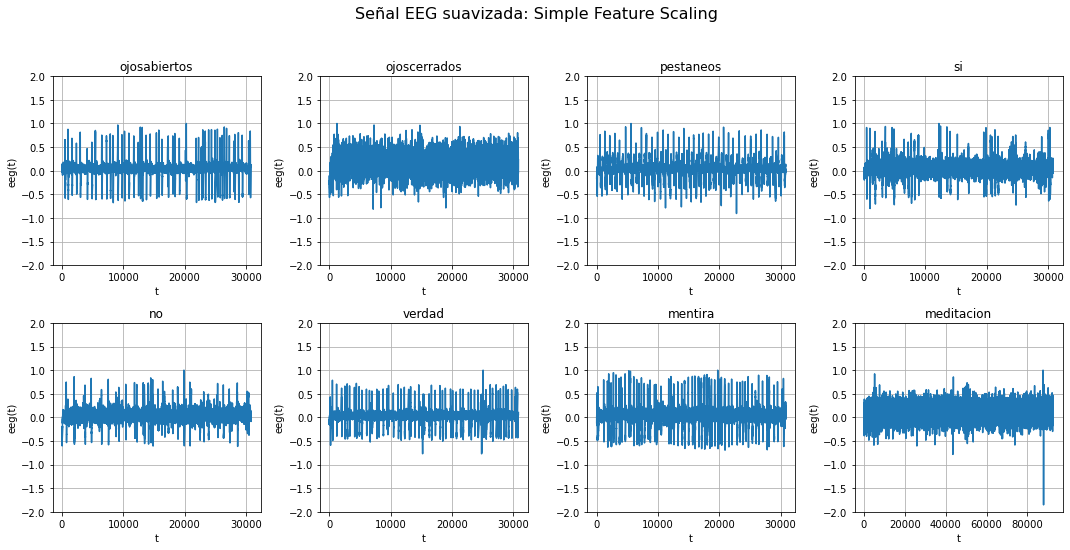

In [147]:
# Numero de filas y de columnas para los subplots

num_rows = 2
num_cols = 4

# Grafico

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
fig.suptitle("Señal EEG suavizada: Simple Feature Scaling", fontsize=16)

y_axis_min = -2
y_axis_max = 2

for i, df in enumerate(nombres_archivos):
    
    row_index = i // num_cols
    col_index = i % num_cols

    # El kernel/máscara está compuesto de 10 valores de 1/10.
    # Cuando esos valores se suman para cada posición, implica que se reemplaza el valor por el promedio
    # de los 5 valores anteriores y 4 posteriores.

    eeg_scaled = simple_feature_scaling(dataframes_dict[df]['eeg'])
    
    x = range(len(eeg_scaled))
    
    axes[row_index, col_index].plot(x, eeg_scaled)
    axes[row_index, col_index].grid()
    axes[row_index, col_index].set_title(df)
    axes[row_index, col_index].set_xlabel("t")
    axes[row_index, col_index].set_ylabel("eeg(t)")
    axes[row_index, col_index].set_ylim(y_axis_min, y_axis_max)

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [43]:
# Min-Max Scaling, Xnew = (Xold - Xmin) / (Xmax - Xmin)

def min_max_scaling(arr):
    """This method applies min-max-scaling
        to a distribution (arr).
    @param arr: An array or list or series object
    @return: The arr with all features min-max scaled
    """

    arr_max = max(arr)
    arr_min = min(arr)
    range_ = arr_max - arr_min

    new_arr = [(i-arr_min)/range_ for i in arr]

    return new_arr

In [46]:
# Let's define an array arr

for df in nombres_archivos:
    print(f'\nMin-Max Scaling for {df}\n')
    eeg = dataframes_dict[df]['eeg']
    eeg_minmax = min_max_scaling(eeg)
    #print(f'Before Scaling...\n min  is {min(eeg)}\n max  is {max(eeg)}\n')
    print(f'After Scaling...\n min is {min(eeg_minmax)}\n max is {max(eeg_minmax)}')


Min-Max Scaling for ojosabiertos

After Scaling...
 min is 0.0
 max is 1.0

Min-Max Scaling for ojoscerrados

After Scaling...
 min is 0.0
 max is 1.0

Min-Max Scaling for pestaneos

After Scaling...
 min is 0.0
 max is 1.0

Min-Max Scaling for si

After Scaling...
 min is 0.0
 max is 1.0

Min-Max Scaling for no

After Scaling...
 min is 0.0
 max is 1.0

Min-Max Scaling for verdad

After Scaling...
 min is 0.0
 max is 1.0

Min-Max Scaling for mentira

After Scaling...
 min is 0.0
 max is 1.0

Min-Max Scaling for meditacion

After Scaling...
 min is 0.0
 max is 1.0


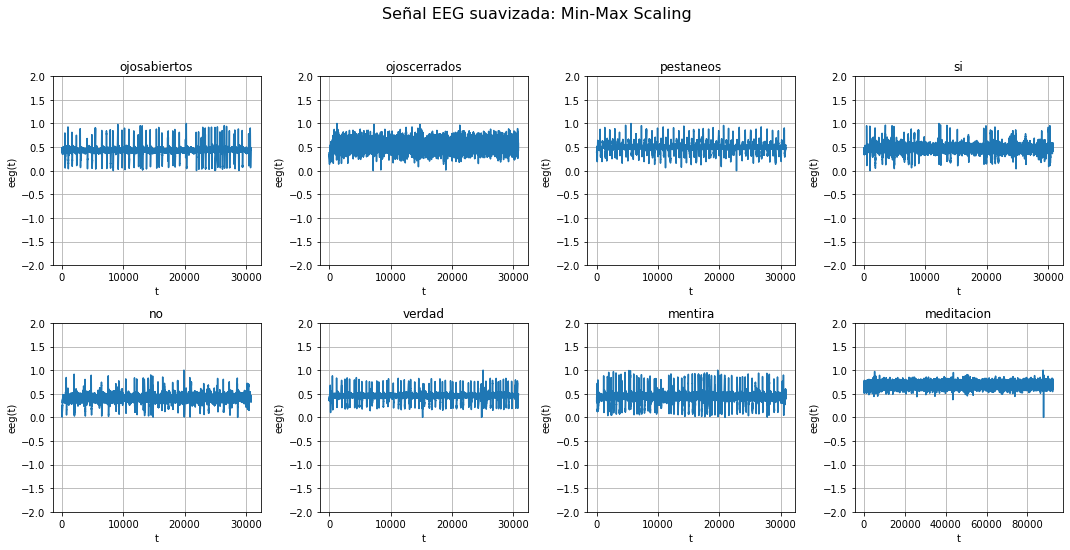

In [146]:
# Numero de filas y de columnas para los subplots

num_rows = 2
num_cols = 4

# Grafico

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
fig.suptitle("Señal EEG suavizada: Min-Max Scaling", fontsize=16)

y_axis_min = -2
y_axis_max = 2

for i, df in enumerate(nombres_archivos):
    
    row_index = i // num_cols
    col_index = i % num_cols

    # El kernel/máscara está compuesto de 10 valores de 1/10.
    # Cuando esos valores se suman para cada posición, implica que se reemplaza el valor por el promedio
    # de los 5 valores anteriores y 4 posteriores.

    eeg_minmax = min_max_scaling(dataframes_dict[df]['eeg'])
    
    x = range(len(eeg_minmax))
    
    axes[row_index, col_index].plot(x, eeg_minmax)
    axes[row_index, col_index].grid()
    axes[row_index, col_index].set_title(df)
    axes[row_index, col_index].set_xlabel("t")
    axes[row_index, col_index].set_ylabel("eeg(t)")
    axes[row_index, col_index].set_ylim(y_axis_min, y_axis_max)

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [ ]:
# Normalization, "Statistical Normalization" means pushing the data to match to a Normal Distribution.
# (Normalization is also considered in terms of vector normalization, divide by the norm.)
# This is also call, "Standarization" = "Statistical Normalization"

# Z-Score, Xnew = Xold - Xmean / Xstd, everything is around -1 to 1

def z_score_norm(arr):
    """Apply z-score normalization
        to an array or series
    """
    mean_ = np.mean(arr)
    std_ = np.std(arr)

    new_arr = [(i-mean_)/std_ for i in arr]

    return new_arr

In [47]:
# Let's define an array arr

for df in nombres_archivos:
    print(f'\nz-score Scaling for {df}\n')
    eeg = dataframes_dict[df]['eeg']
    eeg_zscore = z_score_norm(eeg)
    #print(f'Before Scaling...\n min  is {min(eeg)}\n max  is {max(eeg)}\n')
    print(f'After Scaling...\n min is {min(eeg_zscore)}\n max is {max(eeg_zscore)}')


z-score Scaling for ojosabiertos

After Scaling...
 min is -3.3133473906170097
 max is 4.508672693967688

z-score Scaling for ojoscerrados

After Scaling...
 min is -4.917541302951841
 max is 4.25236918880768

z-score Scaling for pestaneos

After Scaling...
 min is -4.433799036976176
 max is 4.598610561681156

z-score Scaling for si

After Scaling...
 min is -4.627762722655969
 max is 5.372485069163298

z-score Scaling for no

After Scaling...
 min is -4.147086669507692
 max is 6.234052623644498

z-score Scaling for verdad

After Scaling...
 min is -4.582090891753144
 max is 5.663652561487992

z-score Scaling for mentira

After Scaling...
 min is -3.264662599922587
 max is 4.379902615364465

z-score Scaling for meditacion

After Scaling...
 min is -13.340016444761009
 max is 6.101818108044987


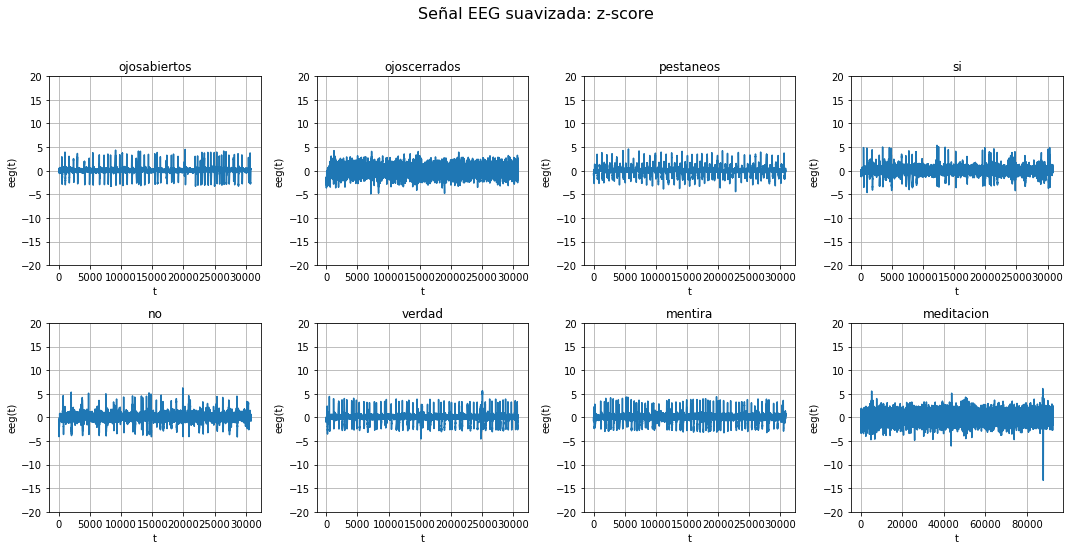

In [145]:
# Numero de filas y de columnas para los subplots

num_rows = 2
num_cols = 4

# Grafico

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
fig.suptitle("Señal EEG suavizada: z-score", fontsize=16)

y_axis_min = -20
y_axis_max = 20

for i, df in enumerate(nombres_archivos):
    
    row_index = i // num_cols
    col_index = i % num_cols

    # El kernel/máscara está compuesto de 10 valores de 1/10.
    # Cuando esos valores se suman para cada posición, implica que se reemplaza el valor por el promedio
    # de los 5 valores anteriores y 4 posteriores.

    eeg_zscore = z_score_norm(dataframes_dict[df]['eeg'])
    x = range(len(eeg_zscore))
    
    axes[row_index, col_index].plot(x, eeg_zscore)
    axes[row_index, col_index].grid()
    axes[row_index, col_index].set_title(df)
    axes[row_index, col_index].set_xlabel("t")
    axes[row_index, col_index].set_ylabel("eeg(t)")
    axes[row_index, col_index].set_ylim(y_axis_min, y_axis_max)

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [50]:
# Box-Cox Normalization:  Transform the data to look more normal N()

# Let's define an array arr

for df in nombres_archivos:
    print(f'\nBox-Cox Normalization Scaling for {df}\n')
    eeg = dataframes_dict[df]['eeg']
    eeg2 = eeg + abs(min(eeg)) + 1
    eeg_boxcox, _ = stats.boxcox(eeg2)
    #print(f'Before Scaling...\n min  is {min(eeg)}\n max  is {max(eeg)}\n')
    print(f'After Scaling...\n min is {min(eeg_boxcox)}\n max is {max(eeg_boxcox)}')


Box-Cox Normalization Scaling for ojosabiertos

After Scaling...
 min is 0.0
 max is 3039.877841105723

Box-Cox Normalization Scaling for ojoscerrados

After Scaling...
 min is 0.0
 max is 643.1736254798656

Box-Cox Normalization Scaling for pestaneos

After Scaling...
 min is 0.0
 max is 977.5442768216304

Box-Cox Normalization Scaling for si

After Scaling...
 min is 0.0
 max is 1763.4865127717121

Box-Cox Normalization Scaling for no

After Scaling...
 min is 0.0
 max is 2628.8700735254383

Box-Cox Normalization Scaling for verdad

After Scaling...
 min is 0.0
 max is 1753.7000285732497

Box-Cox Normalization Scaling for mentira

After Scaling...
 min is 0.0
 max is 1526.156963623114

Box-Cox Normalization Scaling for meditacion

After Scaling...
 min is 0.0
 max is 1390840.66143717


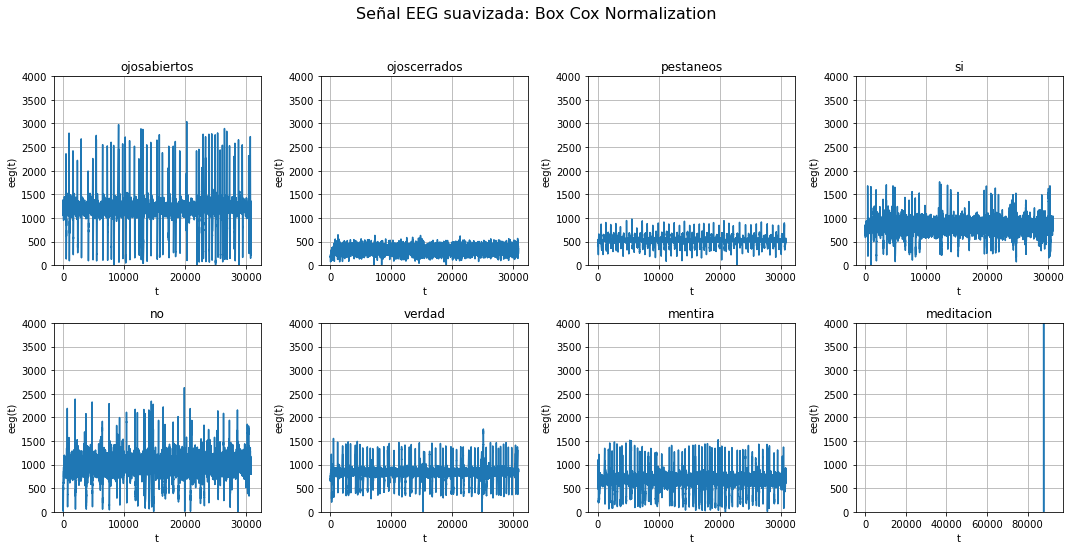

In [144]:
# Numero de filas y de columnas para los subplots

num_rows = 2
num_cols = 4

# Grafico

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
fig.suptitle("Señal EEG suavizada: Box Cox Normalization", fontsize=16)

y_axis_min = 0
y_axis_max = 4000

for i, df in enumerate(nombres_archivos):
    
    row_index = i // num_cols
    col_index = i % num_cols

    # El kernel/máscara está compuesto de 10 valores de 1/10.
    # Cuando esos valores se suman para cada posición, implica que se reemplaza el valor por el promedio
    # de los 5 valores anteriores y 4 posteriores.

    eeg2 = dataframes_dict[df]['eeg'] + abs(min(dataframes_dict[df]['eeg'])) + 1
    eeg_boxcox, _ = stats.boxcox(eeg2)
    
    x = range(len(eeg_boxcox))
    
    axes[row_index, col_index].plot(x, eeg_boxcox)
    axes[row_index, col_index].grid()
    axes[row_index, col_index].set_title(df)
    axes[row_index, col_index].set_xlabel("t")
    axes[row_index, col_index].set_ylabel("eeg(t)")
    axes[row_index, col_index].set_ylim(y_axis_min, y_axis_max)

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## Espectral <a class = 'anchor' id = 'espectral'></a>

In [61]:
# Definimos el filtro bandpass

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [150]:
# Frecuencia de sampleo
N = 512
# sample spacing
T = 1.0 / 512.0

xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))

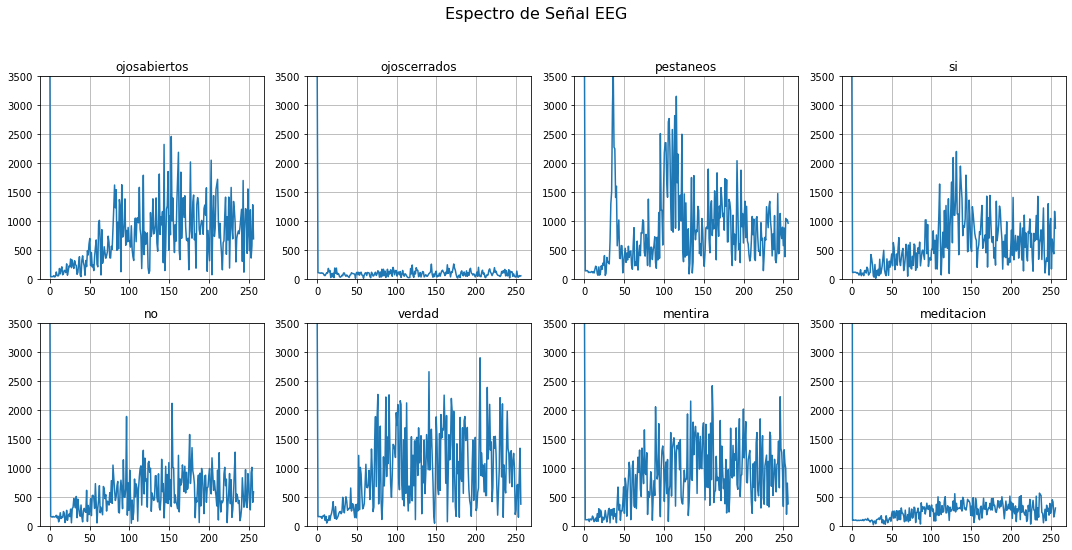

In [152]:
# Aplicamos la transformación de Forier a las series originales

# Numero de filas y de columnas para los subplots

num_rows = 2
num_cols = 4

# Grafico

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
fig.suptitle("Espectro de Señal EEG", fontsize=16)

y_axis_min = 0
y_axis_max = 3500

for i, df in enumerate(nombres_archivos):
    
    row_index = i // num_cols
    col_index = i % num_cols

    # El kernel/máscara está compuesto de 10 valores de 1/10.
    # Cuando esos valores se suman para cada posición, implica que se reemplaza el valor por el promedio
    # de los 5 valores anteriores y 4 posteriores.
    
    y = dataframes_dict[df]['eeg']
    yf = fft(y)
    
    axes[row_index, col_index].plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
    axes[row_index, col_index].grid()
    axes[row_index, col_index].set_title(df)
    axes[row_index, col_index].set_xlabel("")
    axes[row_index, col_index].set_ylabel("")
    axes[row_index, col_index].set_ylim(y_axis_min, y_axis_max)

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

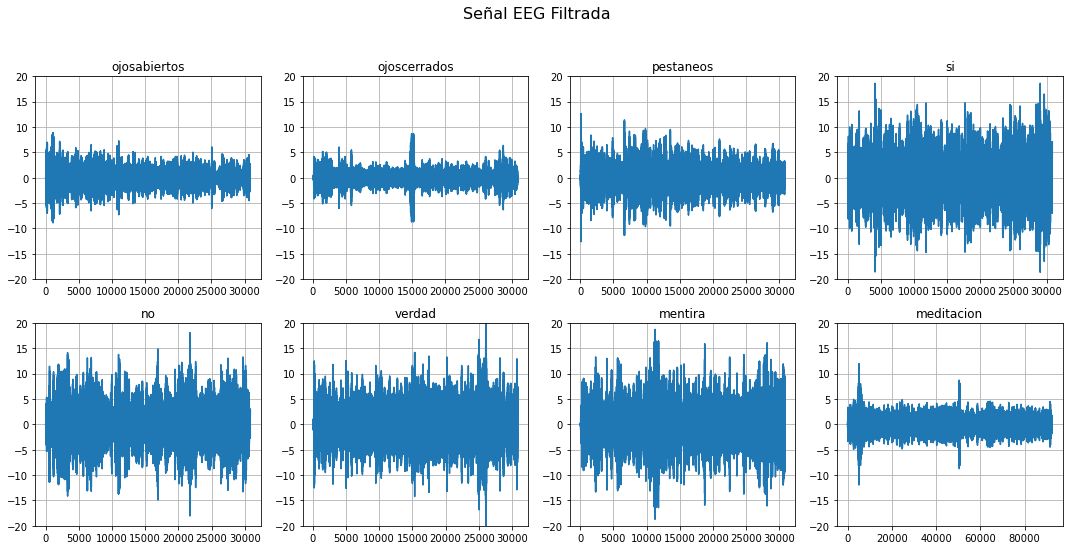

In [158]:
# Aplicamos el filtro bandpass entre 128 y 135 Hz

blow = 128.0
bhigh = 135.0

# Numero de filas y de columnas para los subplots

num_rows = 2
num_cols = 4

# Grafico

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
fig.suptitle("Señal EEG Filtrada", fontsize=16)

y_axis_min = -20
y_axis_max = 20

for i, df in enumerate(nombres_archivos):
    
    row_index = i // num_cols
    col_index = i % num_cols

    # El kernel/máscara está compuesto de 10 valores de 1/10.
    # Cuando esos valores se suman para cada posición, implica que se reemplaza el valor por el promedio
    # de los 5 valores anteriores y 4 posteriores.
    
    y = dataframes_dict[df]['eeg']
    y = butter_bandpass_filter(y, blow, bhigh, 512.0, order = 6)
    x = range(len(y))
    
    axes[row_index, col_index].plot(x, y)
    axes[row_index, col_index].grid()
    axes[row_index, col_index].set_title(df)
    axes[row_index, col_index].set_xlabel("")
    axes[row_index, col_index].set_ylabel("")
    axes[row_index, col_index].set_ylim(y_axis_min, y_axis_max)

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

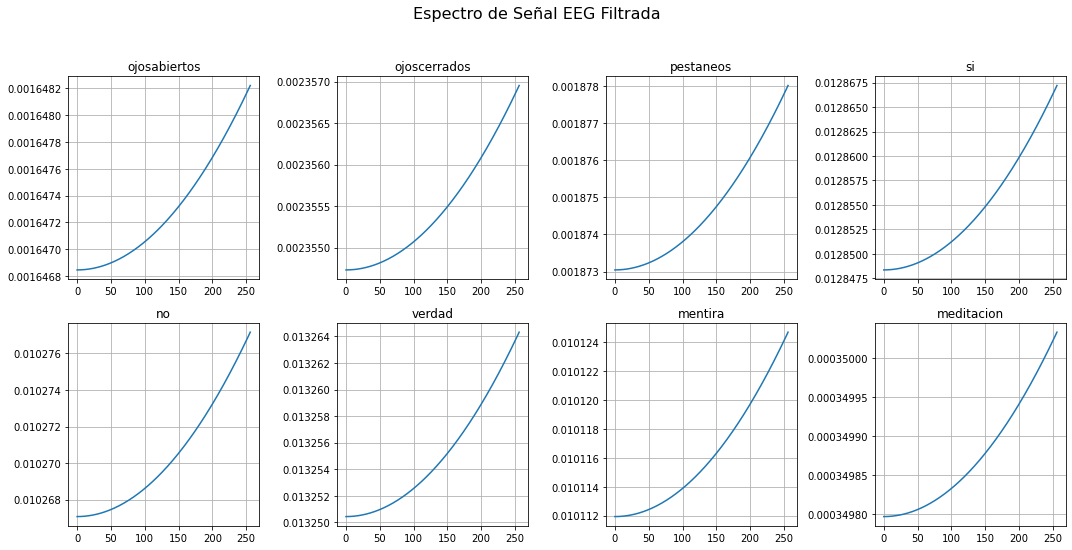

In [161]:
# Aplicamos la transformación de Forier a las series filtradas

blow = 128.0
bhigh = 135.0

# Numero de filas y de columnas para los subplots

num_rows = 2
num_cols = 4

# Grafico

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
fig.suptitle("Espectro de Señal EEG Filtrada", fontsize=16)

for i, df in enumerate(nombres_archivos):
    
    row_index = i // num_cols
    col_index = i % num_cols

    # El kernel/máscara está compuesto de 10 valores de 1/10.
    # Cuando esos valores se suman para cada posición, implica que se reemplaza el valor por el promedio
    # de los 5 valores anteriores y 4 posteriores.
    
    y = dataframes_dict[df]['eeg']
    y = butter_bandpass_filter(y, blow, bhigh, 512.0, order = 6)
    yf = fft(y)
    
    axes[row_index, col_index].plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
    axes[row_index, col_index].grid()
    axes[row_index, col_index].set_title(df)
    axes[row_index, col_index].set_xlabel("")
    axes[row_index, col_index].set_ylabel("")

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

**Densidad Espectral**

In [163]:
# Calculo de la densidad espectral
'''Aplica el filtro y ademas hace la transformada de fourier'''
def psd(y):
    # Number of samplepoints
    N = 512
    # sample spacing
    T = 1.0 / 512.0
    # From 0 to N, N*T, 2 points.
    #x = np.linspace(0.0, 1.0, N)
    #y = 1*np.sin(10.0 * 2.0*np.pi*x) + 9*np.sin(20.0 * 2.0*np.pi*x)

    # Original Bandpass
    fs = 512.0
    fso2 = fs/2
    #Nd,wn = buttord(wp=[9/fso2,11/fso2], ws=[8/fso2,12/fso2],
    #   gpass=3.0, gstop=40.0)
    #b,a = butter(Nd,wn,'band')
    #y = filtfilt(b,a,y)

    y = butter_bandpass_filter(y, 128.0, 135.0, fs, order=6)

    yf = fft(y)
    #xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    #import matplotlib.pyplot as plt
    #plt.plot(xf, 2.0/N * np.abs(yf[0:N/2]))
    #plt.axis((0,60,0,1))
    #plt.grid()
    #plt.show()

    return np.sum(np.abs(yf[0:int(N/2)]))

In [173]:
print('Densidad espectral (N/2 samplepoints) de la señal filtrada EEG del experimento\n')
for df in nombres_archivos:
    print(f'{df}: {psd(dataframes_dict[df]["eeg"]).round(1)}')

Densidad espectral (N/2 samplepoints) de la señal filtrada EEG del experimento

ojosabiertos: 108.0
ojoscerrados: 154.4
pestaneos: 122.9
si: 842.4
no: 673.1
verdad: 868.7
mentira: 663.0
meditacion: 22.9
